In [1]:
import os
from pathlib import Path 
import sys
import matplotlib.pyplot as plt
import numpy as np

sys.path.insert(0, str(Path().absolute().parents[1]))
from experiments.datasets.faces import FaceDataset, FaceLabel
from cv_prince.chap_07_complex_densities.gmm import ExpectationMaximisationGMM, GMMSampler
from cv_prince.chap_07_complex_densities.gmm_face_detection import GMMFaceDetector

In [2]:
root_data_dir = os.environ.get("DATASETS")
data_dir = Path(root_data_dir) / "FDDB"
faces_dir = data_dir / "originalPics"
fold_dir = data_dir / "FDDB-folds"

num_folds = len(list(fold_dir.glob("*ellipseList.txt")))

In [3]:
test_fold = [10]
val_folds = [8, 9]
train_folds = [1, 2, 3, 4, 5, 6, 7]

In [4]:
face_dataset = FaceDataset(annotation_dir=fold_dir, imgs_dir=faces_dir)
print(len(face_dataset))
print(face_dataset.num_face_imgs)

Loading Face Dataset
Face Dataset Loaded
14734
5171


In [5]:
images_to_keep = np.isin(face_dataset.images_to_fold, train_folds)
images_to_keep = np.argwhere(images_to_keep).flatten()

faces_to_keep = np.concat([face_dataset.image_to_face_data[idx] for idx in images_to_keep])
others_to_keep = np.concat(
    [
        face_dataset.image_to_non_face_data[idx] for idx in images_to_keep
        if len(face_dataset.image_to_non_face_data[idx]) > 0
    ]
)

In [6]:
train_faces_arr = face_dataset.faces_arr[faces_to_keep, :]
train_non_faces_arr = face_dataset.non_faces_arr[others_to_keep, :]

train_data = np.concatenate(
    [train_faces_arr, train_non_faces_arr]
)
train_labels = np.array(
    len(train_faces_arr) * [FaceLabel.face] + len(train_non_faces_arr) * [FaceLabel.other]
)

In [ ]:
OVERWRITE = False

face_detector_file = Path("face_detector.pkl")
face_detector = GMMFaceDetector()

if OVERWRITE or not face_detector_file.exists():
    face_detector.fit(train_data, train_labels)
    face_detector.save(face_detector_file)
else:
    face_detector.load(face_detector_file)

  0%|          | 3/1000 [01:49<10:08:42, 36.63s/it]


In [8]:
images_to_keep = np.isin(face_dataset.images_to_fold, val_folds)
images_to_keep = np.argwhere(images_to_keep).flatten()

faces_to_keep = np.concat([face_dataset.image_to_face_data[idx] for idx in images_to_keep])
others_to_keep = np.concat(
    [
        face_dataset.image_to_non_face_data[idx] for idx in images_to_keep
        if len(face_dataset.image_to_non_face_data[idx]) > 0
    ]
)

val_faces_arr = face_dataset.faces_arr[faces_to_keep, :]
val_others_arr = face_dataset.non_faces_arr[others_to_keep, :]

val_data = np.concatenate(
    [val_faces_arr, val_others_arr]
)
val_labels = np.array(
    len(val_faces_arr) * [FaceLabel.face] + len(val_others_arr) * [FaceLabel.other]
)

In [9]:
val_predicts = face_detector.predict(val_data)

In [10]:
confusion = val_labels == val_predicts

accuracy = confusion.sum() / len(val_data)
face_tpr = confusion[val_labels == FaceLabel.face].sum() / len(val_faces_arr)
face_tnr = confusion[val_labels == FaceLabel.other].sum() / len(val_others_arr)

print(f"Accuracy = {accuracy:.2%}")
print(f"Face TPR = {face_tpr:.2%}")
print(f"Face TNR = {face_tnr:.2%}")

Accuracy = 65.34%
Face TPR = 88.28%
Face TNR = 52.52%


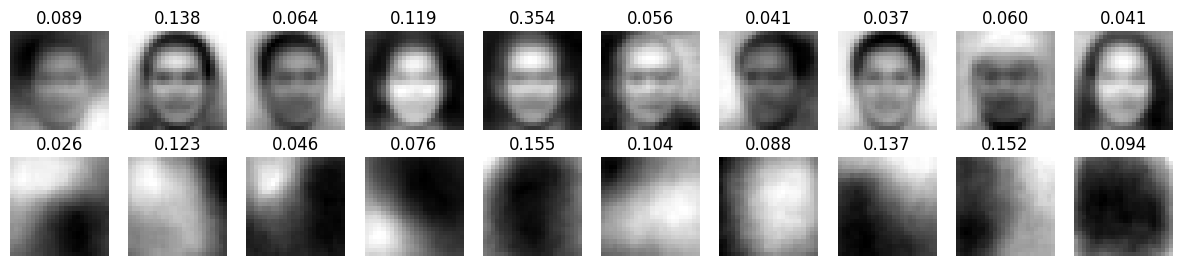

In [11]:
gmm_faces = face_detector.gmm_faces
gmm_others = face_detector.gmm_others

fig, axes = plt.subplots(2, 10, figsize=(15, 3))

for i in range(10):
    axes[0, i].imshow(gmm_faces.gaussians[i].mean.reshape((24, 24)), cmap="gray")
    axes[1, i].imshow(gmm_others.gaussians[i].mean.reshape((24, 24)), cmap="gray")

    axes[0,i].set_title(f"{gmm_faces.weights[i]:.3f}")
    axes[0,i].set_axis_off()
    axes[1,i].set_title(f"{gmm_others.weights[i]:.3f}")
    axes[1,i].set_axis_off()